In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
import pandas as pd
from datasets import load_dataset

# loads entire dataset
dataset = load_dataset("vector-institute/newsmediabias-plus")
df = pd.DataFrame(dataset['train']) # Extract data from the 'train' split
df.to_csv("newsmediabias-plus.csv", index=False)
print(dataset)

README.md:   0%|          | 0.00/5.74k [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


data/dataset_cleaned.parquet:   0%|          | 0.00/72.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/40945 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['unique_id', 'outlet', 'headline', 'url', 'article_text', 'image', 'nlp_label', 'nlp-image_label'],
        num_rows: 40945
    })
})


In [3]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 132.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# Download once if not already
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', ' ', text)         # remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)   # remove URLs
    text = re.sub(r'[^a-zA-Z]', ' ', text)       # keep only letters
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words
             if w not in stop_words and len(w) > 2]
    return ' '.join(words)

# Apply with progress bar
tqdm.pandas()
df['article_text'] = df['article_text'].progress_apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
100%|██████████| 40945/40945 [01:03<00:00, 645.71it/s]


In [5]:
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 27.9 MB/s eta 0:00:00


In [6]:
import pandas as pd
import numpy as np
import random
from nltk.corpus import wordnet
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight

In [7]:
# ------------------------------
# 1️⃣ Manual synonym replacement
# ------------------------------
def synonym_replacement(text, n=1):
    words = text.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if not synonyms:
            continue
        synonym = synonyms[0].lemmas()[0].name().replace("_", " ")
        new_words = [synonym if word == random_word else word for word in new_words]
        num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

In [8]:
# ------------------------------
# 2️⃣ Balance minority class
# ------------------------------
# Map labels to integers
label_mapping = {'Likely to be Unbiased': 0, 'Likely to be Bias': 1}
df['nlp_label'] = df['nlp_label'].map(label_mapping)
df = df.dropna(subset=['nlp_label'])
df['nlp_label'] = df['nlp_label'].astype(int)

# Identify minority class
class_counts = df['nlp_label'].value_counts()
minority_class = class_counts.idxmin()
majority_count = class_counts.max()
minority_df = df[df['nlp_label'] == minority_class]

# Augment minority class until it reaches majority count
augmented_texts = []
augmented_labels = []

while len(minority_df) + len(augmented_texts) < majority_count:
    text = random.choice(minority_df['article_text'].tolist())
    aug_text = synonym_replacement(text, n=1)
    if aug_text != text:
        augmented_texts.append(aug_text)
        augmented_labels.append(minority_class)

df_aug = pd.DataFrame({'article_text': augmented_texts, 'nlp_label': augmented_labels})
df_balanced = pd.concat([df, df_aug]).reset_index(drop=True)
print("Class distribution after augmentation:")
print(df_balanced['nlp_label'].value_counts())

Class distribution after augmentation:
nlp_label
1    28281
0    28281
Name: count, dtype: int64


In [9]:
# ------------------------------
# 3️⃣ Tokenize and pad sequences
# ------------------------------
MAX_LEN = 512
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_balanced['article_text'])
train_sequences = tokenizer.texts_to_sequences(df_balanced['article_text'])
train_pad = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post')
word_index = tokenizer.word_index

In [10]:
# ------------------------------
# 4️⃣ Compute class weights
# ------------------------------
y_all = df_balanced['nlp_label'].values
unique_labels = np.unique(y_all)
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=y_all)
class_weights = dict(zip(unique_labels, class_weights))
print("Class weights:", class_weights)


Class weights: {np.int64(0): np.float64(1.0), np.int64(1): np.float64(1.0)}


In [11]:
# ------------------------------
# 5️⃣ Build embedding matrix
# ------------------------------
EMBEDDING_DIM = 300


In [13]:
from tensorflow.keras.layers import LSTM, Bidirectional, Embedding, Input, Dense, Dropout
from tensorflow.keras.models import Model

inp = Input(shape=(MAX_LEN,))
x = Embedding(len(word_index)+1, EMBEDDING_DIM, trainable=True)(inp)
x = Bidirectional(LSTM(128, return_sequences=False))(x)  # BiLSTM
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
out = Dense(1, activation="sigmoid")(x)

lstm_model = Model(inp, out)
lstm_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
lstm_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 512, 300)       │    33,436,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,909,121 (129.35 MB)

 Trainable params: 33,909,121 (129.35 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Train the model in a single stage
history = lstm_model.fit(
    train_pad,
    y_all,
    validation_split=0.1,
    epochs=5, # Increase epochs as the model has more to learn
    batch_size=32,
    class_weight=class_weights
)

Epoch 1/5
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 100s 63ms/step - accuracy: 0.8754 - loss: 0.3058 - val_accuracy: 0.8996 - val_loss: 0.2565
Epoch 2/5
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 140s 62ms/step - accuracy: 0.9359 - loss: 0.1641 - val_accuracy: 0.9337 - val_loss: 0.1850
Epoch 3/5
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 144s 63ms/step - accuracy: 0.9621 - loss: 0.1002 - val_accuracy: 0.9767 - val_loss: 0.0792
Epoch 4/5
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 139s 62ms/step - accuracy: 0.9768 - loss: 0.0620 - val_accuracy: 0.9871 - val_loss: 0.0530
Epoch 5/5
1591/1591 ━━━━━━━━━━━━━━━━━━━━ 145s 64ms/step - accuracy: 0.9810 - loss: 0.0519 - val_accuracy: 0.9882 - val_loss: 0.0476


1768/1768 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step
Classification Report:
              precision    recall  f1-score   support

    Unbiased       0.99      0.98      0.99     28281
        Bias       0.98      0.99      0.99     28281

    accuracy                           0.99     56562
   macro avg       0.99      0.99      0.99     56562
weighted avg       0.99      0.99      0.99     56562



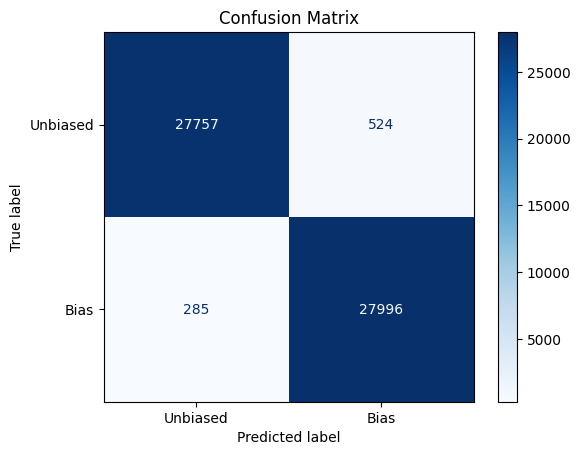

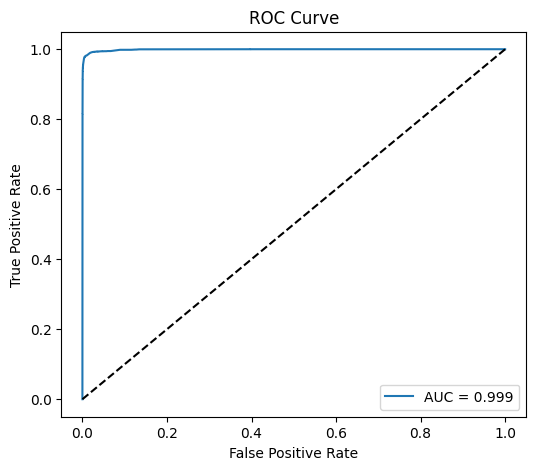

In [16]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ------------------------------
# Predictions
# ------------------------------
y_true = y_all  # true labels from your balanced dataset
y_pred_prob = lstm_model.predict(train_pad)  # predicted probabilities
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # convert to binary labels

# ------------------------------
# 1️⃣ Classification report
# ------------------------------
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Unbiased', 'Bias']))
# ------------------------------
# 2️⃣ Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Unbiased', 'Bias'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()

# ------------------------------
# 2️⃣ ROC Curve & AUC
# ------------------------------
roc_auc = roc_auc_score(y_true, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [ ]:
# Save the entire model
lstm_model.save("article_model.h5")

In [ ]:
from google.colab import files
files.download("article_model.h5")